In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error, r2_score, root_mean_squared_error, mean_absolute_percentage_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
import itertools
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pprint import pprint 
from sklearn.model_selection import train_test_split
from prophet import Prophet
from lightgbm import LGBMRegressor
from sklearn.preprocessing import StandardScaler
from scipy.stats import shapiro


Importing plotly failed. Interactive plots will not work.


In [2]:
transformed_data = pd.read_excel('transformed_data.xlsx')
transformed_data.head()

,latitude,longitude,year,initial_month,season,population,mean_temp,n_cases,date,incidence_rate,location_id
0,11.256531,12.426653,2020,1,winter,200,32,11,2020-01-01,5.5,23
1,11.256531,12.426653,2020,3,spring,200,36,18,2020-03-01,9.0,23
2,11.256531,12.426653,2020,6,summer,200,22,14,2020-06-01,7.0,23
3,11.256531,12.426653,2020,9,autumn,200,32,13,2020-09-01,6.5,23
4,9.081999,8.675277,2020,1,winter,200,19,12,2020-01-01,6.0,15


**Joining Locations**

In [3]:
df = transformed_data.copy()[['date', 'season','location_id','population','mean_temp','n_cases','incidence_rate']]
df = df.sort_values(by=['date','location_id'],ascending=True)

In [4]:
df = df.groupby(['date']).agg({'season':'first','population':'sum','mean_temp':'mean','n_cases':'sum'}).reset_index()
df['incidence_rate'] = (df['n_cases']/df['population'])

In [5]:
df.head()

,date,season,population,mean_temp,n_cases,incidence_rate
0,2020-01-01,winter,1590,25.000000,117,0.073585
1,2020-03-01,spring,1590,29.333333,194,0.122013
2,2020-06-01,summer,1590,26.222222,151,0.094969
3,2020-09-01,autumn,1590,26.000000,144,0.090566
4,2021-01-01,winter,900,23.600000,67,0.074444


# Exploratory Data Analysis

## Timeseries Analysis by Year and Season

In [6]:
year_season_df = df.copy()[['date', 'mean_temp','incidence_rate']]
year_season_df = year_season_df.set_index('date')

In [7]:
year_season_df.loc[pd.to_datetime('2025-01-01')] = [np.nan, np.nan]
year_season_df = year_season_df.asfreq('3ME','ffill')

<Axes: xlabel='date'>

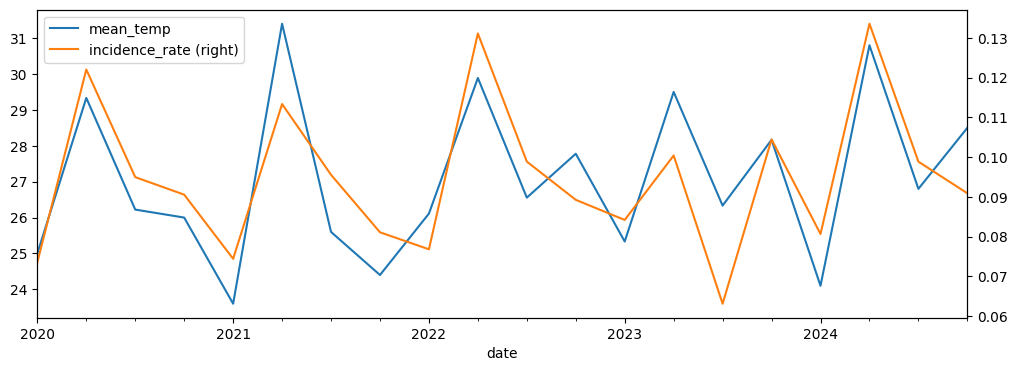

In [8]:
year_season_df.plot(subplots=False, figsize=(12, 4), secondary_y=['incidence_rate'])

### Normality

In [9]:
shapiro_results = shapiro(year_season_df['incidence_rate'])
print('Shapiro-Wilk Test for Normality')
print('p-value: %f' % shapiro_results.pvalue)
print('statistic: %f' % shapiro_results.statistic)

"""
Shapiro-Wilk Test for Normality
p-value: 0.433129
statistic: 0.954071

We performed the Shapiro-Wilk test for normality on the incidence rate data. The hypothesis are:
-H0: The data is normally distributed.
-H1: The data is not normally distributed.

The p-value of the test is 0.433129 which is greater than the significance level of 0.05. Therefore, we fail to reject the null hypothesis, and conclude that the data is normally distributed.
"""

Shapiro-Wilk Test for Normality
p-value: 0.433129
statistic: 0.954071


'\nShapiro-Wilk Test for Normality\np-value: 0.433129\nstatistic: 0.954071\n\nWe performed the Shapiro-Wilk test for normality on the incidence rate data. The hypothesis are:\n-H0: The data is normally distributed.\n-H1: The data is not normally distributed.\n\nThe p-value of the test is 0.433129 which is greater than the significance level of 0.05. Therefore, we fail to reject the null hypothesis, and conclude that the data is normally distributed.\n'

In [10]:
shapiro_results = shapiro(year_season_df['mean_temp'])
print('Shapiro-Wilk Test for Normality')
print('p-value: %f' % shapiro_results.pvalue)
print('statistic: %f' % shapiro_results.statistic)

"""
Shapiro-Wilk Test for Normality
p-value: 0.511884
statistic: 0.958373

We performed the Shapiro-Wilk test for normality on the incidence rate data. The hypothesis are:
-H0: The data is normally distributed.
-H1: The data is not normally distributed.

The p-value of the test is 0.511884 which is greater than the significance level of 0.05. Therefore, we fail to reject the null hypothesis, and conclude that the data is normally distributed.
"""

Shapiro-Wilk Test for Normality
p-value: 0.511884
statistic: 0.958373


'\nShapiro-Wilk Test for Normality\np-value: 0.511884\nstatistic: 0.958373\n\nWe performed the Shapiro-Wilk test for normality on the incidence rate data. The hypothesis are:\n-H0: The data is normally distributed.\n-H1: The data is not normally distributed.\n\nThe p-value of the test is 0.511884 which is greater than the significance level of 0.05. Therefore, we fail to reject the null hypothesis, and conclude that the data is normally distributed.\n'

### Stationarity

In [11]:
ad_fuller_results = adfuller(year_season_df['incidence_rate'].values)
print('ADF Statistic: %f' % ad_fuller_results[0])
print('p-value: %f' % ad_fuller_results[1])
print('Critical Values:')
for key, value in ad_fuller_results[4].items():
	print('\t%s: %.3f' % (key, value))
""""
ADF Statistic: -5.063424
p-value: 0.000017
Critical Values:
	1%: -4.069
	5%: -3.127
	10%: -2.702

We performed the Augmented Dickey-Fuller test to assess the stationarity of the time series. The hypotheses were:
-H0: The time series has a unit root (it is non-stationary).
-H1: The time series does not have a unit root (it is stationary).

The ADF Statistic is less than the critical value at 1%, so we can reject the null hypothesis that the time series is non-stationary, and conclude that the time series is stationary.
"""

ADF Statistic: -5.063424
p-value: 0.000017
Critical Values:
	1%: -4.069
	5%: -3.127
	10%: -2.702


'"\nADF Statistic: -5.063424\np-value: 0.000017\nCritical Values:\n\t1%: -4.069\n\t5%: -3.127\n\t10%: -2.702\n\nWe performed the Augmented Dickey-Fuller test to assess the stationarity of the time series. The hypotheses were:\n-H0: The time series has a unit root (it is non-stationary).\n-H1: The time series does not have a unit root (it is stationary).\n\nThe ADF Statistic is less than the critical value at 1%, so we can reject the null hypothesis that the time series is non-stationary, and conclude that the time series is stationary.\n'

In [12]:
ad_fuller_results = adfuller(year_season_df['mean_temp'].values)
print('ADF Statistic: %f' % ad_fuller_results[0])
print('p-value: %f' % ad_fuller_results[1])
print('Critical Values:')
for key, value in ad_fuller_results[4].items():
	print('\t%s: %.3f' % (key, value))
""""
ADF Statistic: -5.193599
p-value: 0.000009
Critical Values:
	1%: -3.889
	5%: -3.054
	10%: -2.667

We performed the Augmented Dickey-Fuller test to assess the stationarity of the time series. The hypotheses were:
-H0: The time series has a unit root (it is non-stationary).
-H1: The time series does not have a unit root (it is stationary).

The ADF Statistic is less than the critical value at 1%, so we can reject the null hypothesis that the time series is non-stationary, and conclude that the time series is stationary.
"""

ADF Statistic: -5.193599
p-value: 0.000009
Critical Values:
	1%: -3.889
	5%: -3.054
	10%: -2.667


'"\nADF Statistic: -5.193599\np-value: 0.000009\nCritical Values:\n\t1%: -3.889\n\t5%: -3.054\n\t10%: -2.667\n\nWe performed the Augmented Dickey-Fuller test to assess the stationarity of the time series. The hypotheses were:\n-H0: The time series has a unit root (it is non-stationary).\n-H1: The time series does not have a unit root (it is stationary).\n\nThe ADF Statistic is less than the critical value at 1%, so we can reject the null hypothesis that the time series is non-stationary, and conclude that the time series is stationary.\n'

### Seasonality

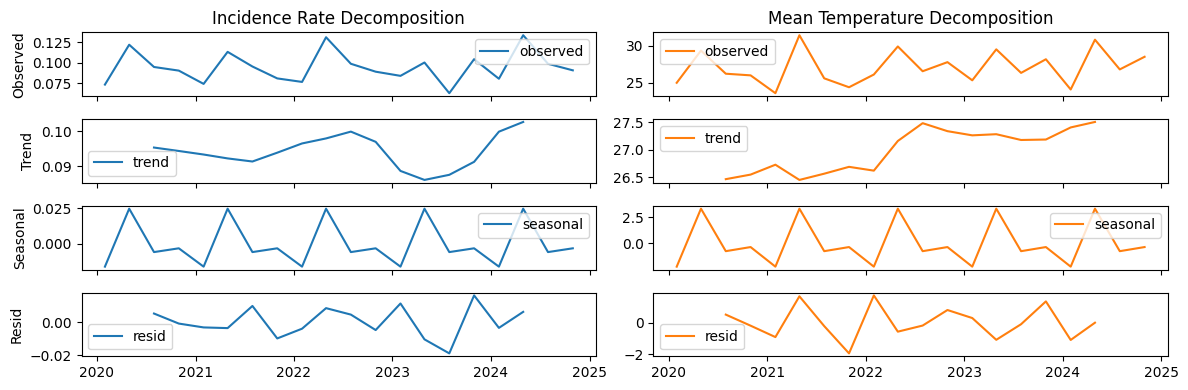

In [13]:
decompose_incidence_rate = seasonal_decompose(year_season_df['incidence_rate'], model="additive", period=4)
decompose_mean_temp = seasonal_decompose(year_season_df['mean_temp'], model="additive", period=4)

fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(12, 4), sharex=True)

ax[0, 0].set_title("Incidence Rate Decomposition")
ax[0, 1].set_title("Mean Temperature Decomposition")

components = ['observed', 'trend', 'seasonal', 'resid']
for i, comp in enumerate(components):
    ax[i, 0].plot(getattr(decompose_incidence_rate, comp), label=comp, color="tab:blue")
    ax[i, 1].plot(getattr(decompose_mean_temp, comp), label=comp, color="tab:orange")
    ax[i, 0].set_ylabel(comp.capitalize())  # Label the y-axis
    ax[i, 0].legend()
    ax[i, 1].legend()

plt.tight_layout()
plt.show()

# Seasonal Decomposition Analysis  

# 1. Incidence Rate:
#    - The trend component indicates a general decline from 2020 to 2023, followed by an upward shift in 2024.
#    - The seasonal component exhibits periodic fluctuations, suggesting a recurring pattern every year.
#    - The residuals remain relatively small, implying that the trend and seasonal components effectively capture most of the variations.

# 2. Mean Temperature:
#    - A consistent upward trend is observed, particularly after 2021, suggesting a long-term warming pattern.
#    - The seasonal component shows strong periodicity, reinforcing the expected influence of seasonal changes in temperature.
#    - The residual variations are larger compared to incidence rates, indicating additional unexplained variability.

# Key Insights:
# - The strong seasonality in temperature may influence the incidence rate, potentially pointing to a correlation between the two variables.
# - The decline in incidence rate from 2020 to 2023, followed by an increase in 2024, may be attributed to external factors 
#   such as policy interventions, public health measures, or environmental influences.
# - The rising temperature trend may have long-term implications for health and disease incidence, warranting further investigation.

### ACF & PACF

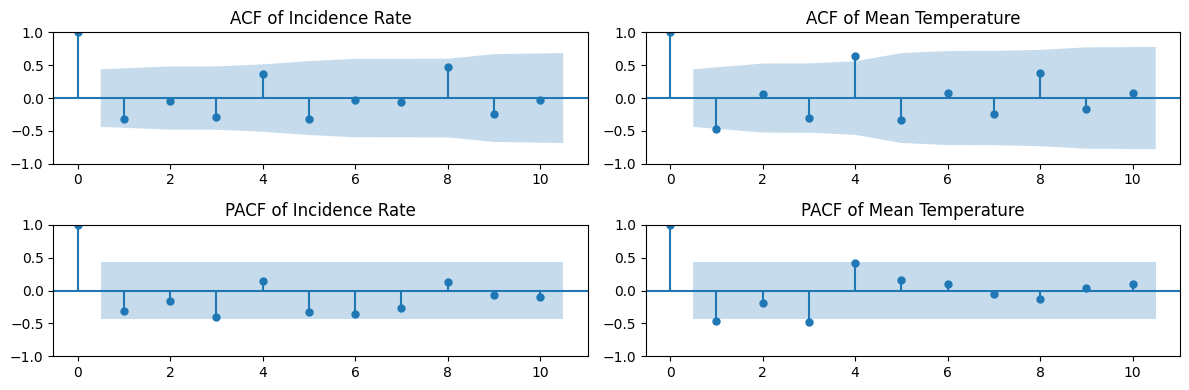

In [14]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12, 4))

# Plot ACF and PACF for incidence_rate
plot_acf(year_season_df['incidence_rate'], ax=ax[0, 0])
plot_pacf(year_season_df['incidence_rate'], ax=ax[1, 0])
ax[0, 0].set_title('ACF of Incidence Rate')
ax[1, 0].set_title('PACF of Incidence Rate')

# Plot ACF and PACF for mean_temp
plot_acf(year_season_df['mean_temp'], ax=ax[0, 1])
plot_pacf(year_season_df['mean_temp'], ax=ax[1, 1])
ax[0, 1].set_title('ACF of Mean Temperature')
ax[1, 1].set_title('PACF of Mean Temperature')

# Adjust layout
plt.tight_layout()
plt.show()

# Interpretation of ACF and PACF plots:

# 1. ACF of Incidence Rate:
#    - The first lag shows a strong correlation (always 1 at lag 0).
#    - Most subsequent lags fall within the confidence interval, indicating weak autocorrelation.
#    - Slightly significant spikes at lag 4 and lag 8 suggest possible seasonality or cyclic patterns.
#    - The slow decay suggests a potential autoregressive (AR) component.

# 2. PACF of Incidence Rate:
#    - No strong cut-off at a specific lag, meaning a pure AR model may not be the best choice.
#    - Weak correlations suggest the absence of a strong AR process.
#    - The lack of a significant pattern implies a simple model (white noise or low-order ARMA) may suffice.

# 3. ACF of Mean Temperature:
#    - Similar to incidence rate, the ACF shows weak correlations beyond lag 0.
#    - Notable spikes at lag 1 and 4  could indicate seasonality.
#    - The gradual decay suggests a possible AR component.

# 4. PACF of Mean Temperature:
#    - The presence of a significant spike at lags 1, 3, 4 suggests that a short-term AR model (e.g., AR(4)) may be appropriate.
#    - The remaining lags fall within the confidence interval, reinforcing that only a small number of lags are influential.

# Conclusion:
# - Both Incidence Rate and Mean Temperature exhibit weak autocorrelation.
# - There are slight hints of periodicity (lag 4 and lag 8 in ACF).
# - Neither series shows strong AR or MA characteristics, meaning a simple ARMA model with low orders might be sufficient.
# - as seasonal decompose confirms seasonality, SARIMA might be appropriate.

### Cross Correlation

In [15]:
lagged_correlation = pd.DataFrame.from_dict(
    {x: [year_season_df['incidence_rate'].corr(year_season_df[x].shift(-t)) for t in range(10)] for x in year_season_df.columns})

lagged_correlation.head(10)

,mean_temp,incidence_rate
0,0.808451,1.000000
1,-0.466636,-0.331464
2,0.167408,-0.052811
3,-0.370786,-0.361957
4,0.689580,0.474602
5,-0.498556,-0.431460
6,-0.071628,-0.053102
7,-0.278853,-0.083364
8,0.828425,0.769705
9,-0.415927,-0.425529


## Timeseries Analysis by Year

In [16]:
year_df = df.copy()[['date', 'mean_temp','incidence_rate']]
year_df = year_df.set_index('date')
year_df = year_df.resample('YE').mean()

<Axes: xlabel='date'>

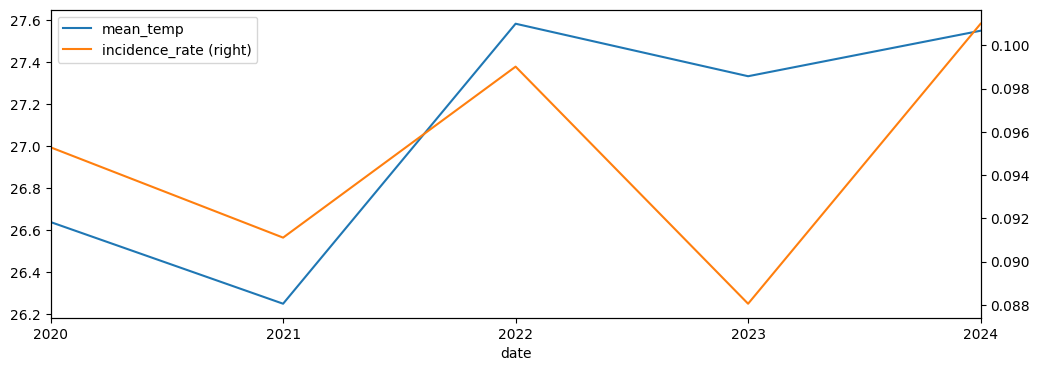

In [17]:
year_df.plot(subplots=False, figsize=(12, 4), secondary_y=['incidence_rate'])

### Stationarity

In [18]:
ad_fuller_results = adfuller(year_df['incidence_rate'].values)
print('ADF Statistic: %f' % ad_fuller_results[0])
print('p-value: %f' % ad_fuller_results[1])
print('Critical Values:')
for key, value in ad_fuller_results[4].items():
	print('\t%s: %.3f' % (key, value))
""""
ADF Statistic: -13.545959
p-value: 0.000000
Critical Values:
	1%: -7.355
	5%: -4.474
	10%: -3.127

We performed the Augmented Dickey-Fuller test to assess the stationarity of the time series. The hypotheses were:
-H0: The time series has a unit root (it is non-stationary).
-H1: The time series does not have a unit root (it is stationary).

The ADF Statistic is less than the critical value at 1%, so we can reject the null hypothesis that the time series is non-stationary, and conclude that the time series is stationary.
"""

ADF Statistic: -13.545959
p-value: 0.000000
Critical Values:
	1%: -7.355
	5%: -4.474
	10%: -3.127


'"\nADF Statistic: -13.545959\np-value: 0.000000\nCritical Values:\n\t1%: -7.355\n\t5%: -4.474\n\t10%: -3.127\n\nWe performed the Augmented Dickey-Fuller test to assess the stationarity of the time series. The hypotheses were:\n-H0: The time series has a unit root (it is non-stationary).\n-H1: The time series does not have a unit root (it is stationary).\n\nThe ADF Statistic is less than the critical value at 1%, so we can reject the null hypothesis that the time series is non-stationary, and conclude that the time series is stationary.\n'

In [19]:
ad_fuller_results = adfuller(year_df['mean_temp'].values)
print('ADF Statistic: %f' % ad_fuller_results[0])
print('p-value: %f' % ad_fuller_results[1])
print('Critical Values:')
for key, value in ad_fuller_results[4].items():
	print('\t%s: %.3f' % (key, value))

""""
ADF Statistic: -1.107792
p-value: 0.711954
Critical Values:
	1%: -7.355
	5%: -4.474
	10%: -3.127

We performed the Augmented Dickey-Fuller test to assess the stationarity of the time series. The hypotheses were:
-H0: The time series has a unit root (it is non-stationary).
-H1: The time series does not have a unit root (it is stationary).

The ADF Statistic is greater than the critical value at 10%, so we can not reject the null hypothesis that the time series is non-stationary, and conclude that the time series is non-stationary.
"""

ADF Statistic: -1.107792
p-value: 0.711954
Critical Values:
	1%: -7.355
	5%: -4.474
	10%: -3.127


'"\nADF Statistic: -1.107792\np-value: 0.711954\nCritical Values:\n\t1%: -7.355\n\t5%: -4.474\n\t10%: -3.127\n\nWe performed the Augmented Dickey-Fuller test to assess the stationarity of the time series. The hypotheses were:\n-H0: The time series has a unit root (it is non-stationary).\n-H1: The time series does not have a unit root (it is stationary).\n\nThe ADF Statistic is greater than the critical value at 10%, so we can not reject the null hypothesis that the time series is non-stationary, and conclude that the time series is non-stationary.\n'

### Seasonality

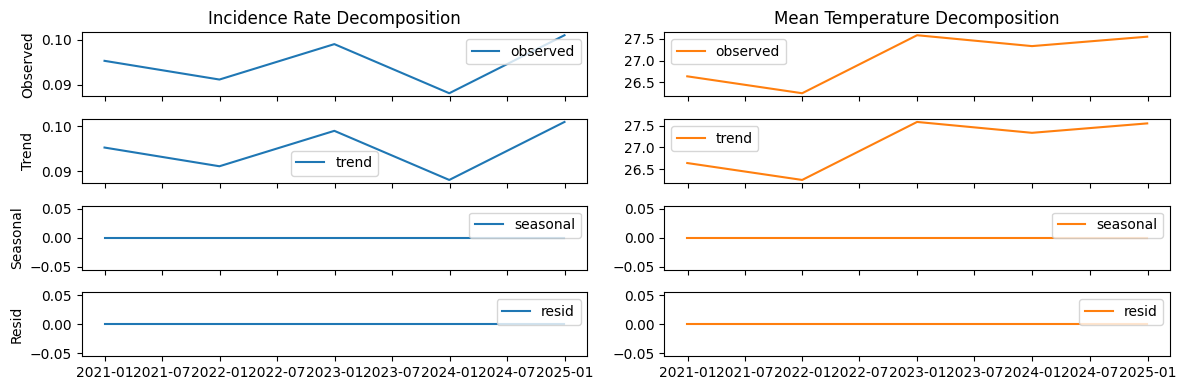

In [20]:
decompose_incidence_rate = seasonal_decompose(year_df['incidence_rate'], model="additive", period=1)
decompose_mean_temp = seasonal_decompose(year_df['mean_temp'], model="additive", period=1)

# Create subplots (4 rows, 2 columns)
fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(12, 4), sharex=True)

# Titles for each column
ax[0, 0].set_title("Incidence Rate Decomposition")
ax[0, 1].set_title("Mean Temperature Decomposition")

# Plot each component
components = ['observed', 'trend', 'seasonal', 'resid']
for i, comp in enumerate(components):
    ax[i, 0].plot(getattr(decompose_incidence_rate, comp), label=comp, color="tab:blue")
    ax[i, 1].plot(getattr(decompose_mean_temp, comp), label=comp, color="tab:orange")
    ax[i, 0].set_ylabel(comp.capitalize())  # Label the y-axis
    ax[i, 0].legend()
    ax[i, 1].legend()

# Adjust layout
plt.tight_layout()
plt.show()

# Seasonal Decomposition Analysis

# 1. Incidence Rate:
#    - The trend component indicates a general decline from 2020 to 2023, followed by an upward shift in 2024.
#    - The seasonal component is not visible due to the short period (1 year).
#    - The residuals are null, indicating that the trend captures all the variations.

# 2. Mean Temperature:
#    - A consistent upward trend is observed, particularly after 2021, suggesting a long-term warming pattern.
#    - The seasonal component is not visible due to the short period (1 year).
#    - The residuals are null, suggesting that the trend effectively models the data.

# Conclusion: Period is not enough to capture seasonality, but the trend is clear in both series.

### ACF & PACF

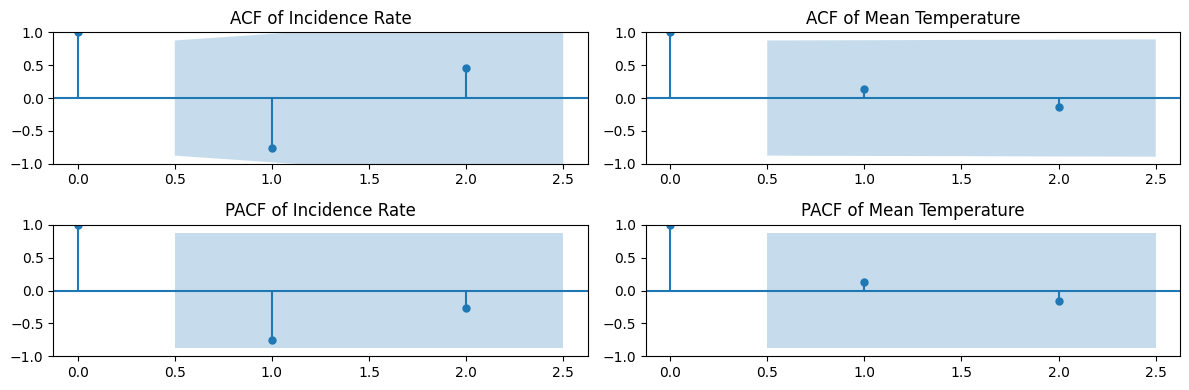

In [21]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12, 4))

# Plot ACF and PACF for incidence_rate
plot_acf(year_df['incidence_rate'], ax=ax[0, 0])
plot_pacf(year_df['incidence_rate'], ax=ax[1, 0])
ax[0, 0].set_title('ACF of Incidence Rate')
ax[1, 0].set_title('PACF of Incidence Rate')

# Plot ACF and PACF for mean_temp
plot_acf(year_df['mean_temp'], ax=ax[0, 1])
plot_pacf(year_df['mean_temp'], ax=ax[1, 1])
ax[0, 1].set_title('ACF of Mean Temperature')
ax[1, 1].set_title('PACF of Mean Temperature')

# Adjust layout
plt.tight_layout()
plt.show()

# Conclusion: The ACF and PACF plots show weak autocorrelation, suggesting that a simple ARMA model may be appropriate for both series.

## Timeseries Analysis by Season

In [22]:
season_df = df.copy()[['season', 'mean_temp','incidence_rate']]
season_df = season_df.groupby(['season']).agg({'mean_temp':'mean','incidence_rate':'mean'}).reset_index()
season_df = season_df.set_index('season')

season_order = ['winter', 'spring', 'summer', 'autumn']
season_df.index = pd.Categorical(season_df.index, categories=season_order, ordered=True)
season_df = season_df.sort_index()


[]

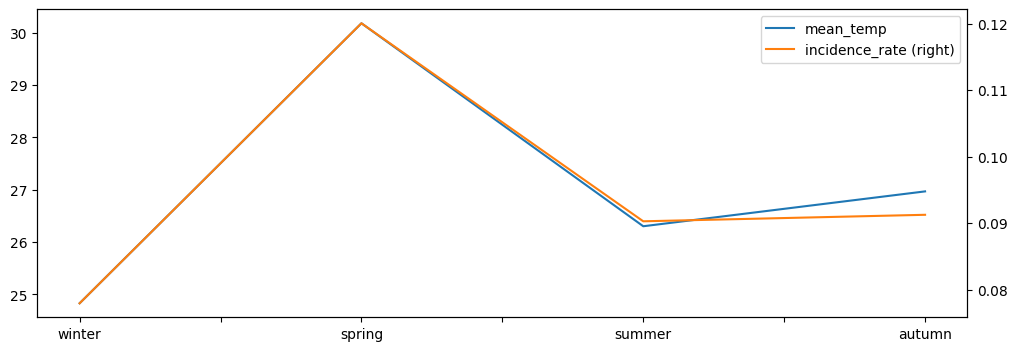

In [23]:
season_df.plot(subplots=False, figsize=(12, 4), secondary_y=['incidence_rate'])
plt.plot()

### Stationarity

In [24]:
ad_fuller_results = adfuller(season_df['incidence_rate'].values)
print('ADF Statistic: %f' % ad_fuller_results[0])
print('p-value: %f' % ad_fuller_results[1])
print('Critical Values:')
for key, value in ad_fuller_results[4].items():
	print('\t%s: %.3f' % (key, value))
""""
ADF Statistic: -1.007280
p-value: 0.750600
Critical Values:
	1%: -10.417
	5%: -5.778
	10%: -3.392

We performed the Augmented Dickey-Fuller test to assess the stationarity of the time series. The hypotheses were:
-H0: The time series has a unit root (it is non-stationary).
-H1: The time series does not have a unit root (it is stationary).

The ADF Statistic is greater than the critical value at 10%, so we can not reject the null hypothesis that the time series is non-stationary, and conclude that the time series is non-stationary.
"""

ADF Statistic: -3.038210
p-value: 0.031477
Critical Values:
	1%: -10.417
	5%: -5.778
	10%: -3.392


'"\nADF Statistic: -1.007280\np-value: 0.750600\nCritical Values:\n\t1%: -10.417\n\t5%: -5.778\n\t10%: -3.392\n\nWe performed the Augmented Dickey-Fuller test to assess the stationarity of the time series. The hypotheses were:\n-H0: The time series has a unit root (it is non-stationary).\n-H1: The time series does not have a unit root (it is stationary).\n\nThe ADF Statistic is greater than the critical value at 10%, so we can not reject the null hypothesis that the time series is non-stationary, and conclude that the time series is non-stationary.\n'

In [25]:
ad_fuller_results = adfuller(season_df['mean_temp'].values)
print('ADF Statistic: %f' % ad_fuller_results[0])
print('p-value: %f' % ad_fuller_results[1])
print('Critical Values:')
for key, value in ad_fuller_results[4].items():
	print('\t%s: %.3f' % (key, value))
""""
ADF Statistic: -0.846654
p-value: 0.805032
Critical Values:
	1%: -10.417
	5%: -5.778
	10%: -3.392

We performed the Augmented Dickey-Fuller test to assess the stationarity of the time series. The hypotheses were:
-H0: The time series has a unit root (it is non-stationary).
-H1: The time series does not have a unit root (it is stationary).

The ADF Statistic is greater than the critical value at 5%, so we can not reject the null hypothesis that the time series is non-stationary, and conclude that the time series is non-stationary.
"""

ADF Statistic: -3.716795
p-value: 0.003883
Critical Values:
	1%: -10.417
	5%: -5.778
	10%: -3.392


'"\nADF Statistic: -0.846654\np-value: 0.805032\nCritical Values:\n\t1%: -10.417\n\t5%: -5.778\n\t10%: -3.392\n\nWe performed the Augmented Dickey-Fuller test to assess the stationarity of the time series. The hypotheses were:\n-H0: The time series has a unit root (it is non-stationary).\n-H1: The time series does not have a unit root (it is stationary).\n\nThe ADF Statistic is greater than the critical value at 5%, so we can not reject the null hypothesis that the time series is non-stationary, and conclude that the time series is non-stationary.\n'

### Seasonality

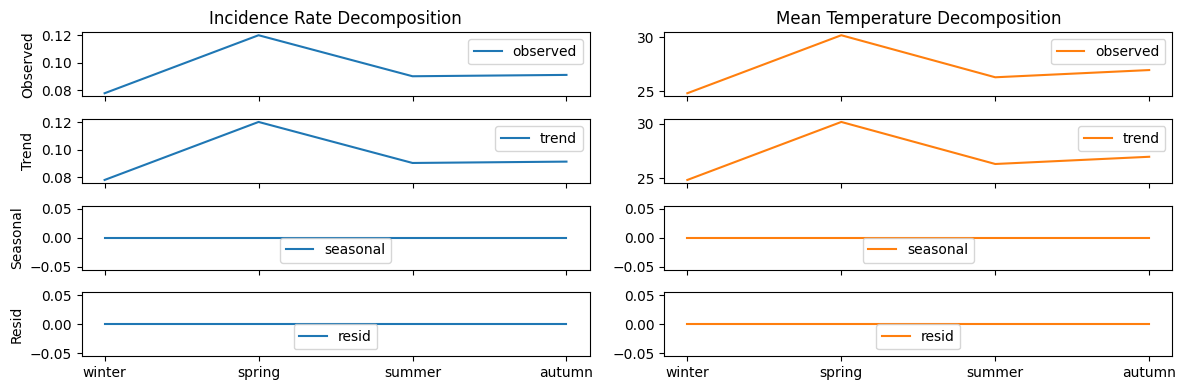

In [26]:
decompose_incidence_rate = seasonal_decompose(season_df['incidence_rate'], model="additive", period=1)
decompose_mean_temp = seasonal_decompose(season_df['mean_temp'], model="additive", period=1)

# Create subplots (4 rows, 2 columns)
fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(12, 4), sharex=True)

# Titles for each column
ax[0, 0].set_title("Incidence Rate Decomposition")
ax[0, 1].set_title("Mean Temperature Decomposition")

# Plot each component
components = ['observed', 'trend', 'seasonal', 'resid']
for i, comp in enumerate(components):
    ax[i, 0].plot(getattr(decompose_incidence_rate, comp), label=comp, color="tab:blue")
    ax[i, 1].plot(getattr(decompose_mean_temp, comp), label=comp, color="tab:orange")
    ax[i, 0].set_ylabel(comp.capitalize())  # Label the y-axis
    ax[i, 0].legend()
    ax[i, 1].legend()

# Adjust layout
plt.tight_layout()
plt.show()

# Seasonal Decomposition Analysis

# In both Incidence Rate and Mean Temperatura, trend is downward to the winter, seasonality is not present, and residuals do not exist, indicating that most of the variability is explained by the trend.
# Conclusion: Period is not enough to capture seasonality, but the trend is clear in both series.

### ACF & PACF

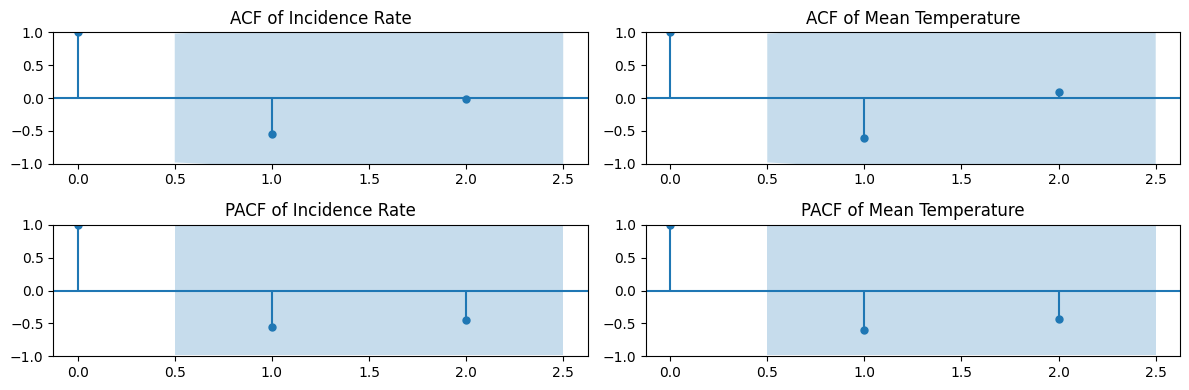

In [27]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12, 4))

# Plot ACF and PACF for incidence_rate
plot_acf(season_df['incidence_rate'], ax=ax[0, 0])
plot_pacf(season_df['incidence_rate'], ax=ax[1, 0])
ax[0, 0].set_title('ACF of Incidence Rate')
ax[1, 0].set_title('PACF of Incidence Rate')

# Plot ACF and PACF for mean_temp
plot_acf(season_df['mean_temp'], ax=ax[0, 1])
plot_pacf(season_df['mean_temp'], ax=ax[1, 1])
ax[0, 1].set_title('ACF of Mean Temperature')
ax[1, 1].set_title('PACF of Mean Temperature')

# Adjust layout
plt.tight_layout()
plt.show()

# Conclusion: The ACF and PACF plots show weak autocorrelation, suggesting that a simple ARMA model may be appropriate for both series.

# Pre-Processing

In [28]:
pre_processing_df = year_season_df.copy()

## Lag Computation

In [29]:
# Function to create lag features
# Adapted from https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/
def series_to_supervised(data, n_in_min=1,n_in_max=4, n_out=1, dropnan=True):
    """"
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
        varNames: List of column names (same size as the number of variables).
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    varNames= data.columns
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in_max, n_in_min-1, -1):
        cols.append(df.shift(i))
        names += [(varNames[j]+'(t-%d)' % (i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [(varNames[j]+'(t)' ) for j in range(n_vars)]
        else:
            names += [(varNames[j]+'(t+%d)' % (i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [30]:
pre_processing_df = series_to_supervised(pre_processing_df, n_in_min=4,n_in_max=8, n_out=1, dropnan=True)

In [38]:
pre_processing_df

,mean_temp(t-8),incidence_rate(t-8),mean_temp(t-7),incidence_rate(t-7),mean_temp(t-6),incidence_rate(t-6),mean_temp(t-5),incidence_rate(t-5),mean_temp(t-4),incidence_rate(t-4),mean_temp(t),incidence_rate(t)
date,,,,,,,,,,,,
2022-01-31,25.000000,0.073585,29.333333,0.122013,26.222222,0.094969,26.000000,0.090566,23.600000,0.074444,26.111111,0.076836
2022-04-30,29.333333,0.122013,26.222222,0.094969,26.000000,0.090566,23.600000,0.074444,31.400000,0.113333,29.888889,0.131073
2022-07-31,26.222222,0.094969,26.000000,0.090566,23.600000,0.074444,31.400000,0.113333,25.600000,0.095556,26.555556,0.098870
2022-10-31,26.000000,0.090566,23.600000,0.074444,31.400000,0.113333,25.600000,0.095556,24.400000,0.081111,27.777778,0.089266
2023-01-31,23.600000,0.074444,31.400000,0.113333,25.600000,0.095556,24.400000,0.081111,26.111111,0.076836,25.333333,0.084211
2023-04-30,31.400000,0.113333,25.600000,0.095556,24.400000,0.081111,26.111111,0.076836,29.888889,0.131073,29.500000,0.100405
2023-07-31,25.600000,0.095556,24.400000,0.081111,26.111111,0.076836,29.888889,0.131073,26.555556,0.098870,26.333333,0.063158
2023-10-31,24.400000,0.081111,26.111111,0.076836,29.888889,0.131073,26.555556,0.098870,27.777778,0.089266,28.166667,0.104453
2024-01-31,26.111111,0.076836,29.888889,0.131073,26.555556,0.098870,27.777778,0.089266,25.333333,0.084211,24.100000,0.080682


## Train/Test Split

In [31]:
X = pre_processing_df.drop(columns=[column for column in pre_processing_df.columns if column == "incidence_rate(t)"], axis=1)
y = pre_processing_df[[column for column in pre_processing_df.columns if column == "incidence_rate(t)"]]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

## Scaling

In [32]:
# We are able to use Standard Scaler since data is normally distributed. If it was not the case, we would use MinMaxScaler.

X_scaler = StandardScaler()
y_scaler = StandardScaler()

X_train_scaled = pd.DataFrame(X_scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
y_train_scaled = pd.DataFrame(y_scaler.fit_transform(y_train), columns=y_train.columns, index=y_train.index)
X_test_scaled = pd.DataFrame(X_scaler.transform(X_test), columns=X_test.columns, index=X_test.index)
y_test_scaled = pd.DataFrame(y_scaler.transform(y_test), columns=y_test.columns, index=y_test.index)

In [61]:
X_train

,mean_temp(t-8),incidence_rate(t-8),mean_temp(t-7),incidence_rate(t-7),mean_temp(t-6),incidence_rate(t-6),mean_temp(t-5),incidence_rate(t-5),mean_temp(t-4),incidence_rate(t-4),mean_temp(t)
date,,,,,,,,,,,
2022-01-31,25.000000,0.073585,29.333333,0.122013,26.222222,0.094969,26.000000,0.090566,23.600000,0.074444,26.111111
2022-04-30,29.333333,0.122013,26.222222,0.094969,26.000000,0.090566,23.600000,0.074444,31.400000,0.113333,29.888889
2022-07-31,26.222222,0.094969,26.000000,0.090566,23.600000,0.074444,31.400000,0.113333,25.600000,0.095556,26.555556
2022-10-31,26.000000,0.090566,23.600000,0.074444,31.400000,0.113333,25.600000,0.095556,24.400000,0.081111,27.777778
2023-01-31,23.600000,0.074444,31.400000,0.113333,25.600000,0.095556,24.400000,0.081111,26.111111,0.076836,25.333333
2023-04-30,31.400000,0.113333,25.600000,0.095556,24.400000,0.081111,26.111111,0.076836,29.888889,0.131073,29.500000
2023-07-31,25.600000,0.095556,24.400000,0.081111,26.111111,0.076836,29.888889,0.131073,26.555556,0.098870,26.333333
2023-10-31,24.400000,0.081111,26.111111,0.076836,29.888889,0.131073,26.555556,0.098870,27.777778,0.089266,28.166667
2024-01-31,26.111111,0.076836,29.888889,0.131073,26.555556,0.098870,27.777778,0.089266,25.333333,0.084211,24.100000


# Modelling

In [43]:
def grid_search(models_params, X_train_scaled, y_train_scaled, X_test_scaled, y_test_scaled, y_scaler):
    
    best_results = {}
    
    for model_class, params in models_params.items():
        best_rmse = np.inf
        best_rsquared = -np.inf
        best_mape = np.inf
        best_params = None
        for combination in itertools.product(*params.values()):
            params = dict(zip(params.keys(), combination))
            if model_class in [ARIMA, SARIMAX]:
                model = model_class(endog = y_train_scaled, exog=X_train_scaled, **params)
                model = model.fit()
                y_pred_scaled = model.forecast(steps=len(y_test_scaled), exog=X_test_scaled).values
            elif model_class == Prophet:
                prophet_train_df = pd.concat([X_train_scaled, y_train_scaled], axis=1)
                prophet_train_df = prophet_train_df.reset_index()
                prophet_train_df = prophet_train_df.rename(columns={'date':'ds', y_train_scaled.columns[0]:'y'})
                prophet_train_X = prophet_train_df.drop(columns=['y'])
                prophet_train_y = prophet_train_df[['ds','y']]

                prophet_test_df = pd.concat([X_test_scaled, y_test_scaled], axis=1)
                prophet_test_df = prophet_test_df.reset_index()
                prophet_test_df = prophet_test_df.rename(columns={'date':'ds', y_train_scaled.columns[0]:'y'})
                prophet_test_X = prophet_test_df.drop(columns=['y'])
                prophet_test_y = prophet_test_df[['ds','y']]

                model = model_class(**params)
                for column in prophet_train_df.columns:
                    if column != 'ds' and column != 'y':
                        model.add_regressor(column)

                model.fit(prophet_train_df)
                y_pred_scaled = model.predict(prophet_test_X)['yhat'].values
            else:
                model = model_class(**params)
                model.fit(X_train_scaled, y_train_scaled)
                y_pred_scaled = model.predict(X_test_scaled)
            
            y_pred = pd.DataFrame(y_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)), index=y_test.index, columns=y_test.columns)
            
            rmse = root_mean_squared_error(y_test, y_pred)
            rsquared = r2_score(y_test, y_pred)
            mape = mean_absolute_percentage_error(y_test, y_pred)
            
            if rmse < best_rmse:
                best_rmse = rmse
                best_rsquared = rsquared
                best_mape = mape
                best_params = params
        
        best_results[model_class] = {
            "best_rmse": best_rmse,
            "best_rsquared": best_rsquared,
            "best_mape": best_mape,
            "best_params": best_params,
            "trained_model": model
        }

        print(f"Best RMSE for {model_class.__name__}: {best_rmse}")
    
    return best_results

In [34]:
models_params = {
    Prophet: {    
        'seasonality_mode': ['multiplicative', 'additive'],
        'changepoint_prior_scale': [0.001, 0.01, 0.1],
        'seasonality_prior_scale': [0.01, 0.1, 1.0],
        'holidays_prior_scale': [0.01, 0.1, 1.0]    
    },
    ARIMA: {
        'order': [(3,0,0)],
    },
    SARIMAX: {
        'order': [(3,0,0)],
        'seasonal_order': [(1,0,1,4)],
    },
    LinearRegression: {
        'fit_intercept': [True],
    },
    RandomForestRegressor: {
        'n_estimators': [10, 20, 30, 40, 50, 100, 150],
        'max_depth': [3, 5, 7],
        'min_samples_split': [2, 4, 6],
        'min_samples_leaf': [2, 4,5,6],
        'random_state': [1]
    },
    LGBMRegressor: {
        'n_estimators': [10, 20, 30, 40, 50, 100, 150],
        'max_depth': [2, 3, 5, 7],
        'learning_rate': [0.01, 0.1, 0.3],
        'subsample': [0.5, 0.7, 1],
        'colsample_bytree': [0.5, 0.7, 1],
        'random_state': [1]
    },
    XGBRegressor: {
        'n_estimators': [10, 20, 30, 40, 50, 100, 150],
        'max_depth': [2, 3, 5, 7],
        'learning_rate': [0.01, 0.1, 0.3],
        'subsample': [0.5, 0.7, 1],
        'colsample_bytree': [0.5, 0.7, 1],
        'random_state': [1]
    },
    MLPRegressor: {
        "hidden_layer_sizes": [(5,), (10,), (20,), (100,), (50,10), (100,20)],
        "activation": ["relu", "tanh",], 
        "solver": ["adam"],
        "alpha": [0.0001, 0.001],
        "learning_rate": ["constant"],
        "max_iter": [10000],
        "random_state": [1],
    }  
}

In [ ]:
results = grid_search(models_params, X_train_scaled, y_train_scaled, X_test_scaled, y_test_scaled, y_scaler)

In [45]:
pprint(results)

{<class 'sklearn.linear_model._base.LinearRegression'>: {'best_mape': 0.28189378003907106,
                                                         'best_params': {'fit_intercept': True},
                                                         'best_rmse': 0.03252604601839396,
                                                         'best_rsquared': -2.0909428629550275,
                                                         'trained_model': LinearRegression()},
 <class 'sklearn.ensemble._forest.RandomForestRegressor'>: {'best_mape': 0.13903867475937012,
                                                            'best_params': {'max_depth': 3,
                                                                            'min_samples_leaf': 2,
                                                                            'min_samples_split': 2,
                                                                            'n_estimators': 150,
                                                 